# Analyse du modèle de centrale de production

Dans ce notebook, est présentée la modélisation de la centrale de production du réseau de chaleur.
La centrale de production dans notre cas est composé de (voir Figure 1):
- Un échangeur géothermie
- une chaudière gaz
- Une pompe
- Un système de régulation de la température de départ

<div style="width:800px;margin:auto; margin:auto;">
<center>
Figure 1 : Schéma d'une centrale de production de chaleur 

![alt text](<Images/centrale de production.jpg>)

<center/>
</div>


**Modélisation de l’échangeur géothermal**

L’échangeur de chaleur géothermal est un échangeur à plaque monté en contre-courant (voir Figure 2). La température de la source géothermale _T_geo_in_ est considérée constante toute au long de l’année et égale à 65°C. Les contraintes réglementaires sur le débit de puisage maximal _M_geo_ dans la nappe et sur la température de rejet minimale _T_geo_out_ imposent que le débit de puisage dans la nappe est toujours inférieur au débit total du réseau (_M_geo_ < _M_res_). 

Dans un souci de simplicité, on choisit de modéliser l’échangeur par un modèle à efficacité constante E=0,95.



<div style="width:1200px;margin:auto; margin:auto;">
<center> Figure 2 : Schéma d'un échangeur géothermal

![alt text](<Images/Echangeur geothermal.jpg>) 
<center/>
</div>

**Modélisation de la chaudière gaz**

La chaudière gaz et l’échangeur géothermal sont montés en série. De ce fait, la chaudière gaz vient en appoint de l’échangeur géothermal afin d’atteindre la température de consigne de départ du réseau si la température en sortie de l’échangeur géothermal est trop basse. On considérera que le rendement de la chaudière η est égal à 0,85.

**Régulation de la température de départ au primaire**

La température du réseau en sortie du site de production est régulée via une loi d’eau linéaire. Ainsi, la température de départ du réseau évolue en fonction de la température extérieure, plus la température extérieure est basse plus la température de départ doit être élevée pour fournir la température nécessaire aux habitations. En outre, les réseaux ne fournissent pas uniquement du chauffage mais aussi de l’eau chaude sanitaire (pas modélisée dans notre cas). Ainsi pour des raisons sanitaires (légionellose) la température de l’ECS ne peut pas être inférieure à 60°C, donc la température de départ du réseau ne peut pas être inférieure à 65°C si on se donne un marge pour tenir compte des pertes thermiques. La loi d’eau doit être dimensionnée en prenant en compte les clients qui demandent la température la plus élevée et les pertes dans les canalisations. 

La loi d'eau au départ du réseau primaire comporte donc deux parties (Figure 3) :
- une partie affine où la température de départ diminue lorsque la température extérieure augmente,
- une partie constante à 65°C pour des températures supérieures à 15°C environ dans notre exemple.


<div style="width:800px;margin:auto; margin:auto;">
<center> Figure 3 : Schéma de la loi d'eau au départ du circuit primaire 


<center/>
</div> 

# Présentation du code

In [1]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt
# from IPython.display import Image
dossier = os.getcwd()

**Paramètres de simulation**

In [2]:
temps_simu = 72 #temps en heures
pas_de_temps = 10 # pas de temps des entrées et sorties en minutes
nb_pdt = int(temps_simu*60/pas_de_temps)
delta_t = 1 # pas de temps de calcul en minutes
nb_dt = int(pas_de_temps/delta_t)

**Constantes**

In [3]:
Rho = 1000 # kg/m3
Cp = 4180 # J/(kg.K)

**Caractéristiques de la centrale de production**

In [4]:
E_geo = 0.95
eta_gaz = 0.85
T_geo_base = 65

**Paramètres de la loi d'eau**

In [5]:
TempRef = 90 #température de consigne pour une température de référence de -10°C
TempMin = 65 #température de consigne mininale à fournir (au-delà d'une température extérieure de 10 °C )
pente = (TempMin-TempRef)/(10-(-10))

**Entrées de la simulation**

In [6]:
"Débit en entrée"
M_res_nom = 10  # kg/s       "Débit nominal

M_res = np.ones(nb_pdt)*M_res_nom*0.8

"Température extérieure "
#Evolution sinusoïdale de la température
Text = [5+5*math.sin(math.pi*t*10/(12*60)-math.pi/2) for t in range(nb_pdt)]

"Température de l'eau en retour du réseau primaire (entrée production)"
#Evolution sinusoïdale de la température
T_res_ret = [50+10*math.sin(math.pi*t*10/(12*60)-math.pi/2*1.2) for t in range(nb_pdt)]


**Initialisation**

In [7]:
T_res_dep= np.zeros(nb_pdt) # Température départ primaire
T_cons_prod = np.zeros(nb_pdt)
P_geo = np.zeros(nb_pdt)
P_gaz = np.zeros(nb_pdt)
P_gaz_reel = np.zeros(nb_pdt)
P_res_tot = np.zeros(nb_pdt)
T_cons_prod = np.zeros(nb_pdt)
T_geo_out = np.zeros(nb_pdt)

**Calcul de la consommation de gaz et énergie fournie**

In [8]:
for t in range(nb_pdt-1):
    "Calcul de la température de consigne au départ primaire"
    T_cons_prod1 = -pente * Text[t] + TempRef + pente*(-7) #loi de chauffe primaire
    if T_cons_prod1 < TempMin:
            T_cons_prod1 = TempMin
    else:
            T_cons_prod1 = -pente * Text[t] + TempRef + pente*(-7)
    T_cons_prod[t] = T_cons_prod1
    
    "calcul de la température de sortie de l'échangeur géothermal"
    if T_res_ret[t] > T_cons_prod1:
        T_res_dep = T_res_ret
        P_geo[t] = 0
        P_gaz[t]= 0       
    else:
        if T_res_ret[t] > T_geo_base:
            T_geo_out[t] = T_res_ret[t]
        else:
            T_geo_out[t] = E_geo * ( T_geo_base - T_res_ret[t] ) +T_res_ret[t] # Calcul de la température de sortie réseau de l'echangeur geothermie
    
        if T_geo_out[t] > T_cons_prod1:
            T_geo_out[t]= T_cons_prod1
            P_geo[t] = Cp * M_res[t] * (T_geo_out[t] - T_res_ret[t] ) # Calcul puissance geothermie
        else:
             P_geo[t] = Cp * M_res[t] * (T_geo_out[t] - T_res_ret[t]) # Calcul puissance geothermie
    
        "calcul de la puissance d'appoint gaz"
        P_gaz[t] = M_res[t] * Cp * (T_cons_prod[t] - T_geo_out[t]) # Calcul puissance chaudière gaz
       
    P_gaz_reel[t] = P_gaz[t] / eta_gaz # calcul puissance gaz réelle
    
    "puissance totale fournie au réseau"
    P_res_tot[t] = P_geo[t] + P_gaz[t]  # calcul puissance totale fournie au réseau
    
#sorties : P_geo, P_gaz_reel, P_res_tot, T_cons_prod, T_geo_out
print('\033[1m'+ f"Le taux d'énergie renouvelable est de {np.round(100*sum(P_geo)/sum(P_res_tot),2)}%")

Le taux d'énergie renouvelable est de 25.87%


**Sorties graphiques**

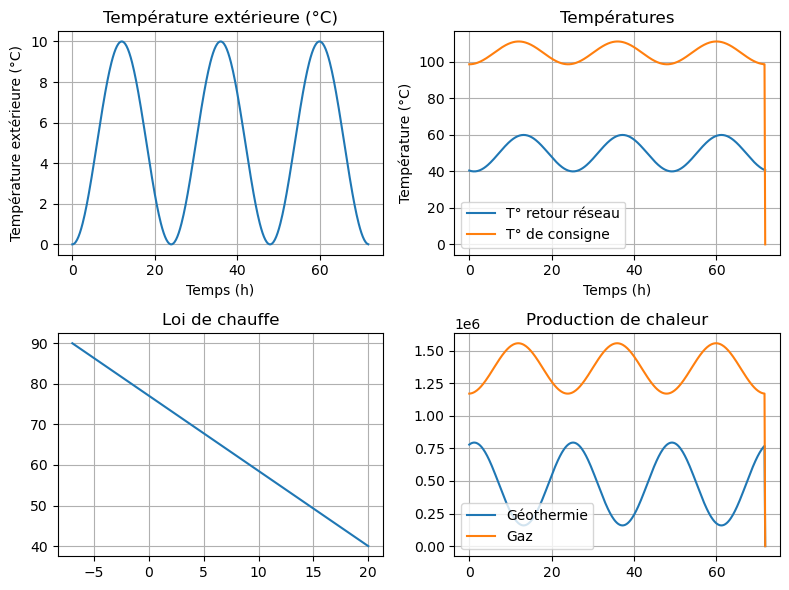

In [9]:
ax_t = np.arange(0,temps_simu,pas_de_temps/60)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.plot(ax_t, Text,label = 'T° ext')
ax0.set_title('Température extérieure (°C)')
ax0.set(xlabel='Temps (h)', ylabel='Température extérieure (°C)')
ax0.grid()

ax1.plot(ax_t, T_res_ret, label = 'T° retour réseau')
ax1.plot(ax_t, T_cons_prod, label = 'T° de consigne')
ax1.set_title('Températures')
ax1.legend()
ax1.set(xlabel='Temps (h)', ylabel='Température (°C)')
ax1.grid()

Texterieur=np.linspace(-7, 20)
Tconsigne = -1.85 * Texterieur + 77
ax2.plot(Texterieur, Tconsigne)
ax2.set_title('Loi de chauffe')
ax2.grid()

ax3.plot(ax_t, P_geo,label = 'Géothermie')
ax3.plot(ax_t, P_gaz,label = 'Gaz')
ax3.legend()
ax3.set_title('Production de chaleur')
ax3.grid()

fig.tight_layout()
fig.canvas.toolbar_position = 'right'

os.chdir(dossier+'\\Outputs')
fig.savefig("Test_production.png")
os.chdir(dossier)

plt.show()

# Analyse du modèle

*<ins>Travail demandé</ins> : à l'aide du code proposé, il vous est proposé d'observer l'évolution des sorties du modèle en en faisant varier les principaux paramètres (loi de chauffe, température de l'eau géothermale) et entrées (température de l'eau en retour du réseau primaire)*

Afin de faciliter les manipulations, il est suggéré d'utiliser le code ci-dessous. 

**N'oubliez pas renommer le fichier de sauvegarde des graphiques à chaque simulation**

Le taux d'énergie renouvelable est de 41.13%


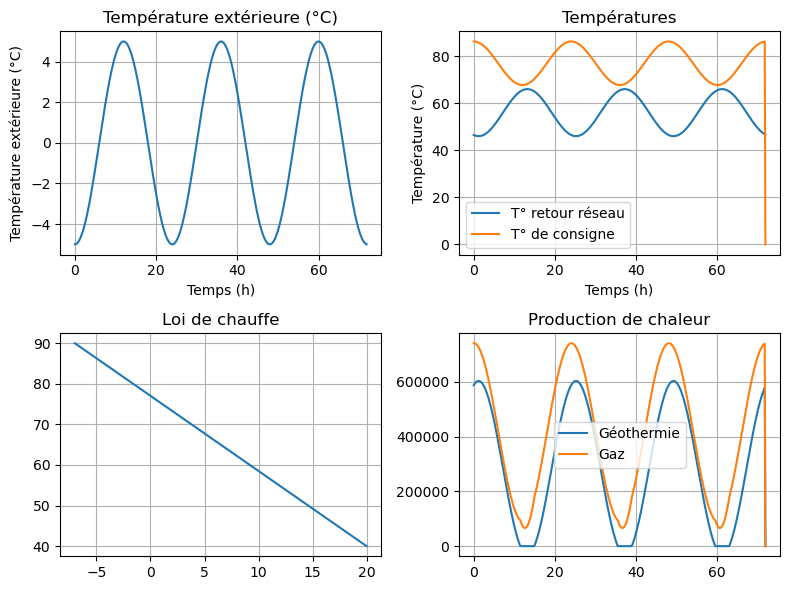

In [10]:
E_geo = 0.95
eta_gaz = 0.85
T_geo_base = 65

"Débit en entrée"
M_res_nom = 10  # kg/s       "Débit nominal

M_res = np.ones(nb_pdt)*M_res_nom*0.8

"Température extérieure "
#Evolution sinusoïdale de la température
Text = [0+5*math.sin(math.pi*t*10/(12*60)-math.pi/2) for t in range(nb_pdt)]

"Température de l'eau en retour du réseau primaire (entrée production)"
#Evolution sinusoïdale de la température
T_res_ret = [56+10*math.sin(math.pi*t*10/(12*60)-math.pi/2*1.2) for t in range(nb_pdt)]

"Initialisation"
T_res_dep= np.zeros(nb_pdt) # Température départ primaire
T_cons_prod = np.zeros(nb_pdt)
P_geo = np.zeros(nb_pdt)
P_gaz = np.zeros(nb_pdt)
P_gaz_reel = np.zeros(nb_pdt)
P_res_tot = np.zeros(nb_pdt)
T_cons_prod = np.zeros(nb_pdt)
T_geo_out = np.zeros(nb_pdt)

for t in range(nb_pdt-1):
    "Calcul de la température de consigne au départ primaire"
    T_cons_prod1 = -1.85 * Text[t] + 77 #loi de chauffe primaire
    if T_cons_prod1 < 60:
            T_cons_prod1 = 60
    else:
            T_cons_prod1 = -1.85 * Text[t] +77
    T_cons_prod[t] = T_cons_prod1
    
    "calcul de la température de sortie de l'échangeur géothermal"
    #insérer situation Tretour supérieure à 65°C
    
    
    if T_res_ret[t] > T_cons_prod1:
        T_res_dep = T_res_ret
        P_geo[t] = 0
        P_gaz[t]= 0       
    else:
        if T_res_ret[t] > T_geo_base:
            T_geo_out[t] = T_res_ret[t]
        else:
            T_geo_out[t] = E_geo * ( T_geo_base - T_res_ret[t] ) +T_res_ret[t] # Calcul de la température de sortie réseau de l'echangeur geothermie
    
        if T_geo_out[t] > T_cons_prod1:
            T_geo_out[t]= T_cons_prod1
            P_geo[t] = Cp * M_res[t] * (T_geo_out[t] - T_res_ret[t] ) # Calcul puissance geothermie
        else:
             P_geo[t] = Cp * M_res[t] * (T_geo_out[t] - T_res_ret[t]) # Calcul puissance geothermie
    
        "calcul de la puissance d'appoint gaz"
        P_gaz[t] = M_res[t] * Cp * (T_cons_prod[t] - T_geo_out[t]) # Calcul puissance chaudière gaz
   
    P_gaz_reel[t] = P_gaz[t] / eta_gaz # calcul puissance gaz réelle
    
    "puissance totale fournie au réseau"
    P_res_tot[t] = P_geo[t] + P_gaz[t]  # calcul puissance totale fournie au réseau
    
#sorties : P_geo, P_gaz_reel, P_res_tot, T_cons_prod, T_geo_out
print('\033[1m'+ f"Le taux d'énergie renouvelable est de {np.round(100*sum(P_geo)/sum(P_res_tot),2)}%")

"Sorties graphiques"
ax_t = np.arange(0,temps_simu,pas_de_temps/60)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.plot(ax_t, Text,label = 'T° ext')
ax0.set_title('Température extérieure (°C)')
ax0.set(xlabel='Temps (h)', ylabel='Température extérieure (°C)')
ax0.grid()

ax1.plot(ax_t, T_res_ret, label = 'T° retour réseau')
ax1.plot(ax_t, T_cons_prod, label = 'T° de consigne')
ax1.set_title('Températures')
ax1.legend()
ax1.set(xlabel='Temps (h)', ylabel='Température (°C)')
ax1.grid()

Texterieur=np.linspace(-7, 20)
Tconsigne = -1.85 * Texterieur + 77
ax2.plot(Texterieur, Tconsigne)
ax2.set_title('Loi de chauffe')
ax2.grid()

ax3.plot(ax_t, P_geo,label = 'Géothermie')
ax3.plot(ax_t, P_gaz,label = 'Gaz')
ax3.legend()
ax3.set_title('Production de chaleur')
ax3.grid()

fig.tight_layout()
fig.canvas.toolbar_position = 'right'

os.chdir(dossier+'\\Outputs')
fig.savefig("Test_production2.png")
os.chdir(dossier)

plt.show()